## Rasterize WKTs and load images

This is heavily incomplete

In [8]:
import numpy as np
import pandas as pd

import io
#import tifffile as tiff
import zipfile

import skimage.transform
#from shapely.wkt import loads as wkt_loads
import cv2

from matplotlib import pyplot as plt
#import skimage.transform

###### First get all images resized to 160x160 and stored in a single array

In [12]:
submission_ids = pd.read_csv('./data/sample_submission.csv',names=['imageID','feature','wkt'],skiprows=1)
training_ids = pd.read_csv('./data/train_wkt_v4.csv',names=['imageID','feature','wkt'],skiprows=1)
grid_sizes = pd.read_csv('./data/grid_sizes.csv',names=['imageID','xmax','ymin'],skiprows=1)
three = zipfile.ZipFile('./data/three_band.zip')
sixteen = zipfile.ZipFile('./data/sixteen_band.zip')

In [3]:
# This just normalizes between the 5th and 95th percentile, and sets anything outside that to 0,1

def normalize(img, l_percentile=5, h_percentile=95):
    output = np.zeros_like(img).astype(np.float32) # return array of zeros with same dimensions as given array
    for i in range(img.shape[0]): # For each band
        min_ = np.percentile(img[i,...], l_percentile)
        max_ = np.percentile(img[i,...], h_percentile)
        norm = (img[i,...] - min_)/ (max_ - min_)
        norm[norm < 0] = 0
        norm[norm > 1] = 1
        output[i,...] = norm

    return output.astype(np.float32)

In [4]:
def get_polygons(imageID, class_):
    img = training_ids[training_ids.imageID == imageID]
    img_wkt = img[img.feature == class_].wkt
    polygon = None
    if len(img_wkt) > 0:
        assert len(img_wkt) == 1 # test condition, trigger error if it's false, i.e. there are multiple wkts here
        polygon = wkt_loads(img_wkt.values[0]) # from shapely.wkt import loads as wkt_loads
    return polygon

def get_coordinates(polygons, raster_img_size, xmax, ymin):
    perimeters = []
    interiors = []
    
    if polygons is None:
        return None
    
    for k in range(len(polygons)):
        # Finds the outer coords of the polygon
        perimeter = np.array(list(polygons[k].exterior.coords))
        # Converts the coords using the scaling factor
        perimeter_contour = convert_coords(perimeter, raster_img_size, xmax, ymin)
        # Appends the outer coords to a list
        perimeters.append(perimeter_contour)
        # Then for each interior in that polygon...
        for i in polygons[k].interiors:
            # Finds the interior coords
            interior = np.array(list(i.coords))
            # Converts the coords using the scaling factor 
            interior_contour = convert_coords(interior, raster_img_size, xmax, ymin)
            # Appends them to a list
            interiors.append(interior_contour)
    return perimeters, interiors

def convert_coords(coords, img_size, xmax, ymin):
    img_h, img_w = img_size
    width_prime = img_w*(img_w / (img_w + 1))
    height_prime = img_h*(img_h / (img_h + 1))
    
    xf = width_prime / xmax
    yf = height_prime / ymin
    
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords = np.round(coords).astype(np.int32)
    return coords

def plot_mask(raster_img_size, coordinates):
    msk = np.zeros(raster_img_size, np.uint8)
    
    if coordinates is None:
        return msk
    
    perim_list, interior_list = coordinates
    cv2.fillPoly(msk, perim_list, 1)
    cv2.fillPoly(msk, interior_list, 0)
    return msk

def make_masks(raster_size, imageID, class_):
    # First get the xmax and ymax
    xmax, ymin = grid_sizes[grid_sizes.imageID == imageID].iloc[0, 1:].astype(float)
    
    # Next, get the polygon list from the train_wkts file
    polygons = get_polygons(imageID,class_)
    
    # Convert polygons to contours and re-factor the coords
    coordinates = get_coordinates(polygons, raster_size, xmax, ymin)
    
    # Makes actual image masks from the coords
    mask = plot_mask(raster_size, coordinates)
    return mask

In [ ]:
# Make training images and masks
img_h,img_w = 160,160
train_imgs = {}
train_msks = {}

for imageID in sorted(training_ids['imageID'].unique()):
    print(imageID)
    image_id_image = []
    image_id_msks = []
    # Open the threeband zipfile and get the image
    with three.open('three_band/{}.tif'.format(imageID)) as f:
        img = tiff.imread(io.BytesIO(f.read())).astype(np.float32)
        img = normalize(img)
        img = skimage.transform.resize(img,(img.shape[0],img_h,img_w))
        image_id_image.append(img)
    
    # Open the sixteen band zipfile and get the images
    for k in ['A','M','P']:
        with sixteen.open('sixteen_band/{}_{}.tif'.format(imageID,k)) as f:
            img = tiff.imread(io.BytesIO(f.read())).astype(np.float32)
        
            if k == 'P': # This image has one channel, so we need to add a new axis so it's dims match the others
                img = img[np.newaxis,...]

            img = normalize(img)
            img = skimage.transform.resize(img,(img.shape[0],img_h,img_w))
            image_id_image.append(img)
    
    # Iterate over n_classes and generate masks for the image
    for class_ in range(10):
        image_id_msks.append(make_masks((img_h,img_w),imageID,class_))
    
    train_imgs[imageID] = np.concatenate(image_id_image,axis=0)
    train_msks[imageID] = np.array(image_id_msks)

np.save('./data/train_imgs.npy',train_imgs)
np.save('./data/train_msks.npy',np.array(train_msks))

In [6]:
train_imgs = np.load('./data/train_imgs.npy').item()
train_msks = np.load('./data/train_msks.npy').item()

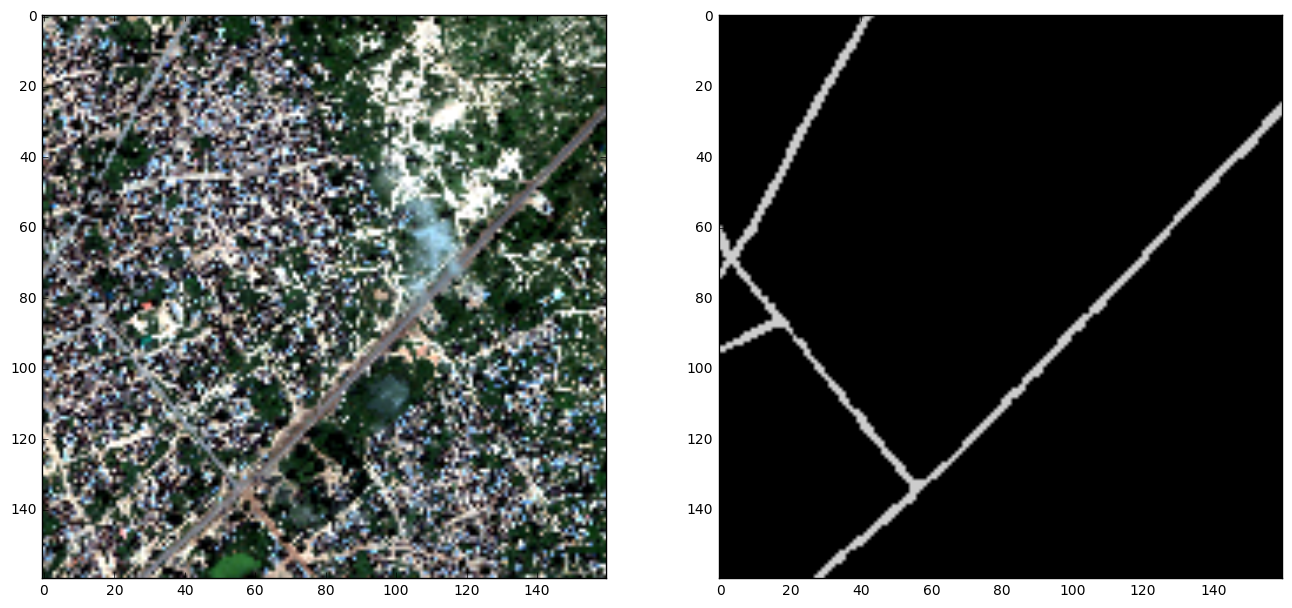

In [17]:
def plot_all(i,class_):
    imageID = list(train_imgs.keys())[i]
    
    fig = plt.figure(figsize=(16,16))

    ax1 = fig.add_subplot(121)
    ax1.imshow(np.rollaxis(train_imgs[imageID],0,3)[:,:,:3])

    ax2 = fig.add_subplot(122)
    ax2.imshow(train_msks[imageID][class_,...],cmap='spectral')
    
    plt.show()
plot_all(9,3)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


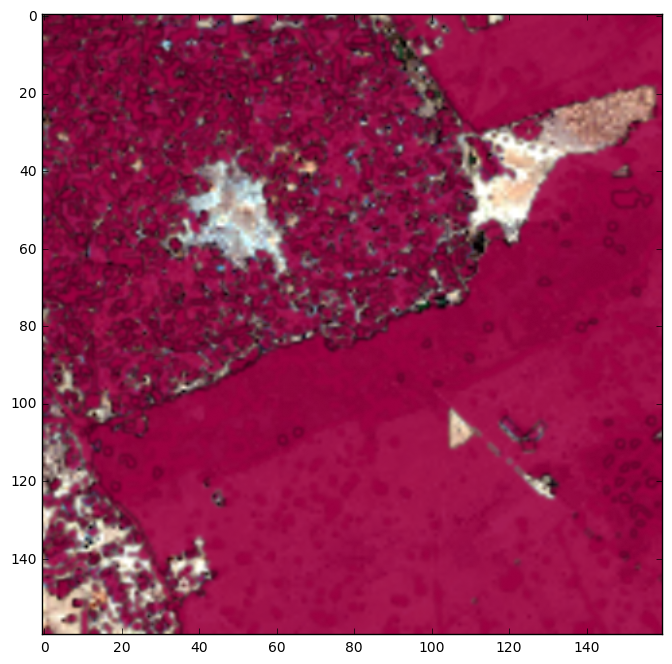

In [59]:
def plot_all(i):
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    
    imageID = list(train_imgs.keys())[i]
    msk = train_msks[imageID].astype(np.float32)
    
    ax1.imshow(np.rollaxis(train_imgs[imageID],0,3)[:,:,:3])
    
    for i in range(10):
        msk[i,...] /= (i+1)
        ax1.imshow(np.ma.masked_where(msk[i,...] == 0, msk[i,...]),cmap='Spectral',alpha=0.9,interpolation='bicubic')
    
    plt.show()
plot_all(9)

In [22]:
np.ma.masked_where?

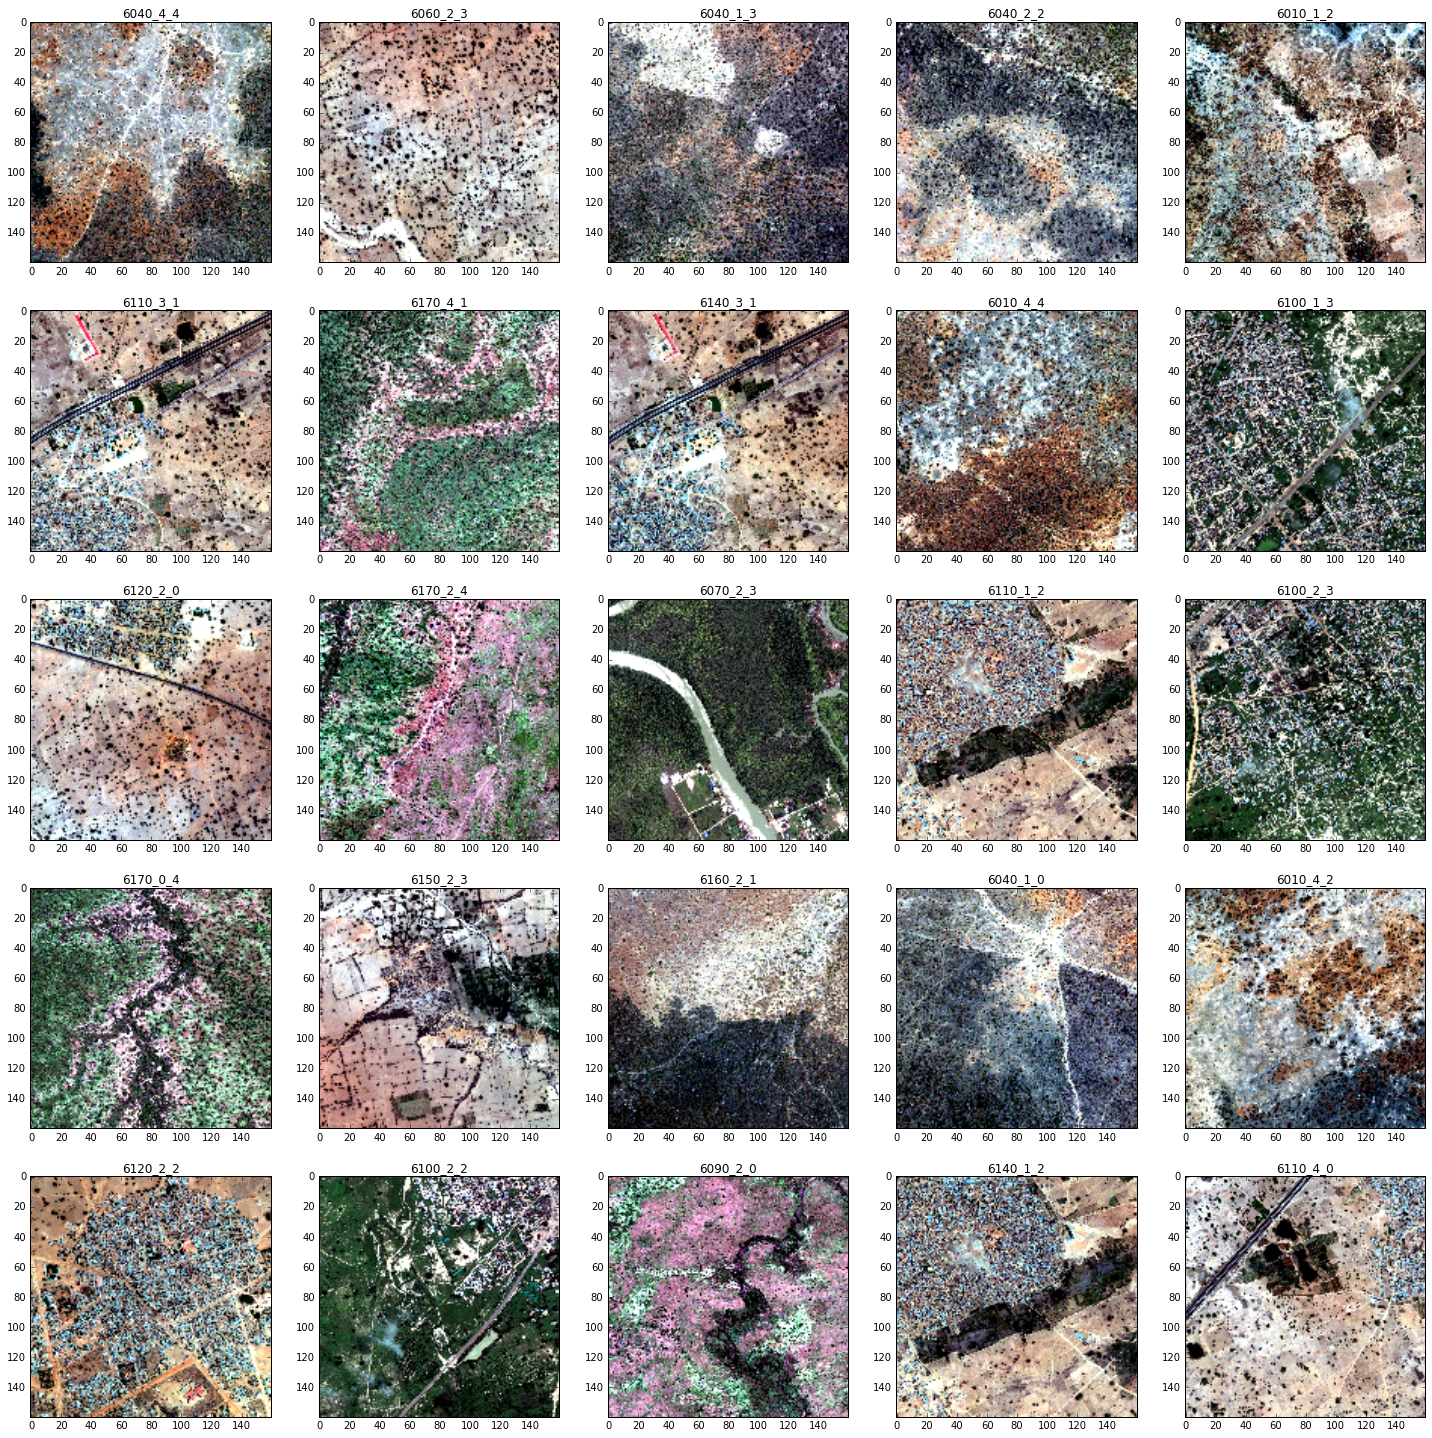

In [82]:
def plot_imgs():
    
    fig = plt.figure(figsize=(25,25))

    for i in range(5):
        for k in range(5):
            imageID = list(train_imgs.keys())[i*5+k] 
            ax = fig.add_subplot(5,5,i*5+k+1)
            ax.imshow(np.rollaxis(train_imgs[imageID],0,3)[:,:,:3])
            ax.set_title(imageID)
    
    plt.show()
plot_imgs()

In [51]:
x = np.concatenate([i[np.newaxis,...] for i in train_imgs.values()],axis=0)
y = np.concatenate([i[np.newaxis,...] for i in train_msks.values()],axis=0)


print('x:',x.shape,'\ny:',y.shape)

x: (25, 20, 160, 160) 
y: (25, 10, 160, 160)


In [ ]:
# Now make a submission

submission_images = {}

for id in sorted(submission_ids['imageID'].unique()):
    
    image_id_image = []
    
    # Open the threeband zipfile and get the image
    with three.open('three_band/{}.tif'.format(id)) as f:
        img = tiff.imread(io.BytesIO(f.read())).astype(np.float32)
        img = normalize(img)
        img = skimage.transform.resize(img,(img.shape[0],160,160))
        image_id_image.append(img)
    
    # Open the sixteen band zipfile and get the images
    for k in ['A','M','P']:
        with sixteen.open('sixteen_band/{}_{}.tif'.format(id,k)) as f:
            img = tiff.imread(io.BytesIO(f.read())).astype(np.float32)
        
            if k == 'P':
                img = img[np.newaxis,...]

            img = normalize(img)
            img = skimage.transform.resize(img,(img.shape[0],160,160))
            image_id_image.append(img)
            
    submission_images[id] = np.concatenate(image_id_image,axis=0)

np.save('./data/submission_images.npy',train_imgs)